In [1]:
import pandas as pd
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline


#directories
import os
from os import listdir
from os.path import isfile, join

import itertools
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte
\
import skimage.transform
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Model
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense , Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D ,Dropout
# from keras.layers import 

# for saving model
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

Using TensorFlow backend.


In [0]:
classes = ['ardhabaddhapadmottanasana','ekapadabakasana','natarajasana',
           'parivrttaardhachandrasana','parivrttasuryayantrasana','salambasirsasana',
           'svargadvijasana','tittibihasana','vrishchikasana','vyaghrasana']

Initiate batch import

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_path = '/content/drive/My Drive/capstone/'
cat_1_folder  = drive_path + '500_ardhabaddhapadmottanasana/'
cat_2_folder  = drive_path + '500_ekapadabakasana/'
cat_3_folder  = drive_path + '500_natarajasana/'
cat_4_folder  = drive_path + '500_parivrttaardhachandrasana/'
cat_5_folder  = drive_path + '500_parivrttasuryayantrasana/'
cat_6_folder  = drive_path + '500_salambasirsasana/'
cat_7_folder  = drive_path + '500_svargadvijasana/'
cat_8_folder  = drive_path + '500_tittibihasana/'
cat_9_folder  = drive_path + '500_vrishchikasana/'
cat_10_folder = drive_path + '500_vyaghrasana/'

In [0]:
folders_path = [cat_1_folder,cat_2_folder,cat_3_folder, 
                cat_4_folder, cat_5_folder, cat_6_folder, 
                cat_7_folder, cat_8_folder, cat_9_folder, cat_10_folder ]

In [6]:
all_images =[]
for i,path in enumerate(folders_path):
  ls = []
  for f in listdir(path):
    if isfile(join(path, f)):
      if 'DS' not in f:
        if '._' not in f:
          ls.append([path+f,f,classes[i]])
    # ls = [[path+f,f,classes[i]] for f in listdir(path) if isfile(join(path, f)) if ('DS' or '._' ) not in f ]
  print('{} ,numer of images for {} : {}'.format(i+1,classes[i],len(ls)))
  all_images.extend(ls)


1 ,numer of images for ardhabaddhapadmottanasana : 553
2 ,numer of images for ekapadabakasana : 560
3 ,numer of images for natarajasana : 570
4 ,numer of images for parivrttaardhachandrasana : 600
5 ,numer of images for parivrttasuryayantrasana : 550
6 ,numer of images for salambasirsasana : 580
7 ,numer of images for svargadvijasana : 574
8 ,numer of images for tittibihasana : 608
9 ,numer of images for vrishchikasana : 665
10 ,numer of images for vyaghrasana : 560


In [7]:
df =pd.DataFrame(all_images,columns=['image_path','image_name','category'])
print(df.shape)
df.head()

(5820, 3)


,image_path,image_name,category
0,/content/drive/My Drive/capstone/500_ardhabadd...,ardhabaddhapadmottanasana_1009.jpg,ardhabaddhapadmottanasana
1,/content/drive/My Drive/capstone/500_ardhabadd...,ardhabaddhapadmottanasana_1001.jpg,ardhabaddhapadmottanasana
2,/content/drive/My Drive/capstone/500_ardhabadd...,ardhabaddhapadmottanasana_1004.jpg,ardhabaddhapadmottanasana
3,/content/drive/My Drive/capstone/500_ardhabadd...,ardhabaddhapadmottanasana_1001_2.jpg,ardhabaddhapadmottanasana
4,/content/drive/My Drive/capstone/500_ardhabadd...,ardhabaddhapadmottanasana_1005.jpg,ardhabaddhapadmottanasana


In [0]:
from sklearn.model_selection import train_test_split
train, tempt = train_test_split(df, train_size=0.6, shuffle = True, stratify = df.category)
valid, test  = train_test_split(tempt, test_size=0.5, shuffle = True, stratify = tempt.category)

In [11]:
size = (224,224)
train_batch_size = 32
batch_size =16
epoch = 500

train_steps = math.ceil(train.shape[0]/train_batch_size)
valid_steps = math.ceil(valid.shape[0]/batch_size)
test_steps  = math.ceil(test.shape[0]/batch_size)
train_steps,valid_steps,test_steps

(110, 73, 73)

In [0]:
# we create two instances with the same arguments
data_gen_args = dict(rescale=1./255,
                    #  featurewise_center=True,
                    #  featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range = 0.1,
                     horizontal_flip = True,
                     vertical_flip = True,
                     zoom_range=0.2)
dat_gen_args_test = dict(rescale=1./255)

In [13]:
train_generator = ImageDataGenerator(**data_gen_args).flow_from_dataframe(
    dataframe     = train,
    directory     = None,
    x_col         = 'image_path',
    y_col         = 'category',
    target_size   = size,
    color_mode    = 'rgb',
    classes       = classes,
    class_mode    = "categorical",
    batch_size    = train_batch_size,
    shuffle       = True,
    seed          = 27,
    save_format   = 'jpg',
    interpolation = "bicubic", 
    validate_filenames = True)

val_generator = ImageDataGenerator(**dat_gen_args_test).flow_from_dataframe(
    dataframe     = valid,
    directory     = None,
    x_col         = 'image_path',
    y_col         = 'category',
    target_size   = size,
    color_mode    = 'rgb',
    classes       = classes,
    class_mode    = "categorical",
    batch_size    = batch_size,
    shuffle       = True,
    seed          = 27,
    save_format   = 'jpg',
    interpolation = "bicubic", 
    validate_filenames = True)

test_generator = ImageDataGenerator(**dat_gen_args_test).flow_from_dataframe(
    dataframe     = test,
    directory     = None,
    x_col         = 'image_path',
    y_col         = 'category',
    target_size   = size,
    color_mode    = 'rgb',
    classes       = classes,
    class_mode    = "categorical",
    batch_size    = batch_size,
    shuffle       = False,
    seed          = 27,
    save_format   = 'jpg',
    interpolation = "bicubic", 
    validate_filenames = True)


Found 3492 validated image filenames belonging to 10 classes.
Found 1164 validated image filenames belonging to 10 classes.
Found 1164 validated image filenames belonging to 10 classes.


### Use pretrained models

In [14]:
MobileNetV2_model = keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3), alpha=1.0, include_top=False, 
                                                                  weights='imagenet', input_tensor=None, pooling='avg', classes=10)
MobileNetV2_model.summary()












9412608/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_____

Epoch 1/500
110/110 [==============================] - 1901s 17s/step - loss: 2.0846 - acc: 0.2105 - val_loss: 3.9843 - val_acc: 0.1237
Epoch 2/500
110/110 [==============================] - 102s 928ms/step - loss: 1.8379 - acc: 0.2955 - val_loss: 3.4410 - val_acc: 0.1890
Epoch 3/500
110/110 [==============================] - 103s 932ms/step - loss: 1.6688 - acc: 0.3719 - val_loss: 2.0684 - val_acc: 0.3643
Epoch 4/500
110/110 [==============================] - 103s 935ms/step - loss: 1.4833 - acc: 0.4665 - val_loss: 5.0315 - val_acc: 0.2088
Epoch 5/500
110/110 [==============================] - 103s 937ms/step - loss: 1.2486 - acc: 0.5846 - val_loss: 1.6467 - val_acc: 0.4880
Epoch 6/500
110/110 [==============================] - 103s 939ms/step - loss: 1.2003 - acc: 0.5997 - val_loss: 3.1887 - val_acc: 0.3127
Epoch 7/500
110/110 [==============================] - 104s 945ms/step - loss: 1.0646 - acc: 0.6511 - val_loss: 11.4233 - val_acc: 0.1177
Epoch 8/500
110/110 [====================

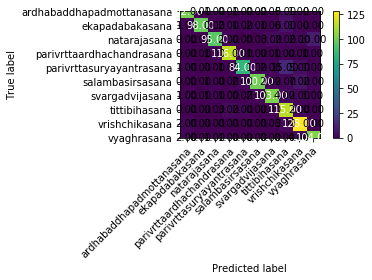

In [17]:
model = MobileNetV2_model

for layer in model.layers:
    layer.traiable = False

Dense_5 = Dense(1280,activation ='relu')(model.output)
Dense_4 = Dense(512,activation ='relu')(Dense_5)
Dense_3 = Dense(256,activation ='relu')(Dense_4)
Dense_2 = Dense(128,activation ='relu')(Dense_3)
Dense_1 = Dense(64,activation ='relu')(Dense_2)
output  = Dense(10,activation ='softmax')(Dense_1)


model = Model(inputs=model.inputs, outputs=output)
model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy',metrics =['accuracy'])

# model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

model.fit_generator(train_generator, steps_per_epoch = train_steps,
                validation_data=val_generator, validation_steps=valid_steps,
                epochs=epoch, verbose=1,callbacks=[es])
model.evaluate_generator(val_generator,steps=valid_steps )

#save model into directory
model.save(drive_path +'IncepResNetV2_model.h5')

test_generator.reset() #need to reset
predictions = model.predict_generator(test_generator,steps=test_steps,verbose=1)
pred_label=[np.argmax(image_class) for image_class in predictions]
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_label_class = [labels[k] for k in pred_label]
# pred_label_class

test_generator.reset() #need to reset
y_true = test_generator.classes

print(len(y_true),len(pred_label))
cm = confusion_matrix(y_true,pred_label)
print(cm)
plot_confusion_matrix(y_true, pred_label,cm)


testing_df = pd.DataFrame(y_true,columns = ['true_label'])
testing_df['pred_label'] = pred_label
testing_df['result'] = ''
for i, rows in enumerate(testing_df.result):
    if testing_df.loc[i,'true_label'] == testing_df.loc[i,'pred_label']:
        testing_df.loc[i,'result']= 1
    elif testing_df.loc[i,'true_label'] != testing_df.loc[i,'pred_label']:
        testing_df.loc[i,'result']= 0



In [0]:
def plot_confusion_matrix(y_true, y_pred,cm):
    
    np.set_printoptions(precision=2)

    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax




In [19]:
test.reset_index(inplace=True, drop=True)
test

,image_path,image_name,category
0,/content/drive/My Drive/capstone/500_svargadvi...,svargadvijasana_922.jpg,svargadvijasana
1,/content/drive/My Drive/capstone/500_parivrtta...,parivrttasuryayantrasana_200.jpg,parivrttasuryayantrasana
2,/content/drive/My Drive/capstone/500_ardhabadd...,ardhabaddhapadmottanasana_421.jpg,ardhabaddhapadmottanasana
3,/content/drive/My Drive/capstone/500_ekapadaba...,ekapadabakasana_844.jpg,ekapadabakasana
4,/content/drive/My Drive/capstone/500_svargadvi...,svargadvijasana_565.jpg,svargadvijasana
...,...,...,...
1159,/content/drive/My Drive/capstone/500_parivrtta...,parivrttasuryayantrasana_604.jpg,parivrttasuryayantrasana
1160,/content/drive/My Drive/capstone/500_tittibiha...,tittibhasana_378.jpg,tittibihasana
1161,/content/drive/My Drive/capstone/500_salambasi...,salambasirsasana_1426.jpg,salambasirsasana
1162,/content/drive/My Drive/capstone/500_salambasi...,salambasirsasana_1100.jpg,salambasirsasana


In [20]:
testing_df

,true_label,pred_label,result
0,6,6,1
1,4,7,0
2,0,0,1
3,1,5,0
4,6,6,1
...,...,...,...
1159,4,7,0
1160,7,7,1
1161,5,5,1
1162,5,5,1


In [21]:
combine_test = pd.concat([test,testing_df], axis =1)
combine_test

,image_path,image_name,category,true_label,pred_label,result
0,/content/drive/My Drive/capstone/500_svargadvi...,svargadvijasana_922.jpg,svargadvijasana,6,6,1
1,/content/drive/My Drive/capstone/500_parivrtta...,parivrttasuryayantrasana_200.jpg,parivrttasuryayantrasana,4,7,0
2,/content/drive/My Drive/capstone/500_ardhabadd...,ardhabaddhapadmottanasana_421.jpg,ardhabaddhapadmottanasana,0,0,1
3,/content/drive/My Drive/capstone/500_ekapadaba...,ekapadabakasana_844.jpg,ekapadabakasana,1,5,0
4,/content/drive/My Drive/capstone/500_svargadvi...,svargadvijasana_565.jpg,svargadvijasana,6,6,1
...,...,...,...,...,...,...
1159,/content/drive/My Drive/capstone/500_parivrtta...,parivrttasuryayantrasana_604.jpg,parivrttasuryayantrasana,4,7,0
1160,/content/drive/My Drive/capstone/500_tittibiha...,tittibhasana_378.jpg,tittibihasana,7,7,1
1161,/content/drive/My Drive/capstone/500_salambasi...,salambasirsasana_1426.jpg,salambasirsasana,5,5,1
1162,/content/drive/My Drive/capstone/500_salambasi...,salambasirsasana_1100.jpg,salambasirsasana,5,5,1


In [0]:
model.save(drive_path +'MobileNetV2_model.h5')


In [0]:
combine_test.to_csv(drive_path+'MobileNetV2_test_csv.csv')